# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [14]:
#!pip install --upgrade pip

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


In [3]:
# TODO: Install any packages that you might need
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 137.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 216.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [4]:
# TODO: Import any packages that you might need
import sagemaker
import boto3

In [5]:

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
session = boto3.session.Session()
region = session.region_name


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-01 10:44:21--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.0MB/s    in 27s     

2023-02-01 10:44:51 (39.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [7]:
#TODO: Fetch and upload the data to AWS S3
path = "dogImages"
prefix= "sagemaker/image_classification_dogs"
#inputs = sagemaker_session.upload_data(path=path, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-815844343266/sagemaker/image_classification_dogs


In [6]:
import os
num_features = len(os.listdir("dogImages/train/"))
num_features

133

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
import sagemaker
import boto3
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
session = boto3.session.Session()
region = session.region_name


In [8]:
inputs = "s3://sagemaker-us-east-1-815844343266/sagemaker/image_classification_dogs"

In [9]:

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [6]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

In [8]:
#TODO: Create estimators for your HPs
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2, #There is no balance enough to run multiple jobs
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [9]:
# TODO: Fit your estimator
tuner.fit(inputs)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................!


In [24]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
hyperparameters = best_estimator.hyperparameters()


2023-02-01 12:55:20 Starting - Preparing the instances for training
2023-02-01 12:55:20 Downloading - Downloading input data
2023-02-01 12:55:20 Training - Training image download completed. Training in progress.
2023-02-01 12:55:20 Uploading - Uploading generated training model
2023-02-01 12:55:20 Completed - Resource retained for reuse


In [25]:
hyperparameters

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '3',
 'lr': '0.0023556834650745387',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-01-12-45-32-381"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-815844343266/pytorch-training-2023-02-01-12-45-32-381/source/sourcedir.tar.gz"'}

In [11]:
hyperparameters = {'batch-size': 256,
 'epochs': 3,
 'lr': 0.0023556834650745387}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

In [13]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [14]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [15]:
estimator.fit(inputs)

2023-02-01 16:26:12 Starting - Starting the training job...
2023-02-01 16:26:39 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-01 16:27:39 Downloading - Downloading input data.......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-01 16:28:45,881 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-01 16:28:45,884 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-01 16:28:45,892 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-01 16:28:45,895 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-01 16:28:46,081 sagemaker-training-toolkit INFO 

In [16]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2023-02-01-16-26-11-627
[2023-02-01 16:51:31.220 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:113 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-815844343266/pytorch-training-2023-02-01-16-26-11-627/debug-output
[2023-02-01 16:51:31.622 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:113 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-01 16:51:32.642 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:113 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'lay

In [ ]:
estimator.latest_job_debugger_artifacts_path()

In [ ]:
training_job_name

In [3]:
!pip install jinja2==3.0.0

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 65.0 MB/s eta 0:00:00
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.9
    Uninstalling Jinja2-2.9:
      Successfully uninstalled Jinja2-2.9

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [17]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import os
import IPython

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-815844343266/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-815844343266/pytorch-training-2023-02-01-16-26-11-627/profiler-output


Profiler data from system is available


In [39]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [40]:
estimator.output_path, estimator.latest_training_job.job_name

('s3://sagemaker-us-east-1-815844343266/',
 'pytorch-training-2023-02-01-16-26-11-627')

In [41]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-815844343266/pytorch-training-2023-02-01-16-26-11-627/rule-output


In [42]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-02-01 16:50:50     365193 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-01 16:50:50     212262 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-01 16:50:45        192 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-01 16:50:45        200 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-01 16:50:45       2074 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-01 16:50:45        127 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-01 16:50:45        199 pytorch-training-2023-02-01-16-26-11-627/rule-output/ProfilerReport/profiler-output/profiler-re

In [43]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:815844343266:processing-job/pytorch-training-2023-02-0-lossnotdecreasing-aa53cf67',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 2, 1, 16, 50, 56, 798000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:815844343266:processing-job/pytorch-training-2023-02-0-vanishinggradient-869b9cc7',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 2, 1, 16, 50, 56, 798000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:815844343266:processing-job/pytorch-training-2023-02-0-overfit-02dfac36',
  'RuleEvaluati

In [44]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [45]:
# TODO: Display the profiler output
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [23]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

-----------------!

In [77]:
import numpy as np
from PIL import Image

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
# CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/




In [78]:
image_path = "dogImages/valid/006.American_eskimo_dog/American_eskimo_dog_00460.jpg"
image = Image.open(image_path)

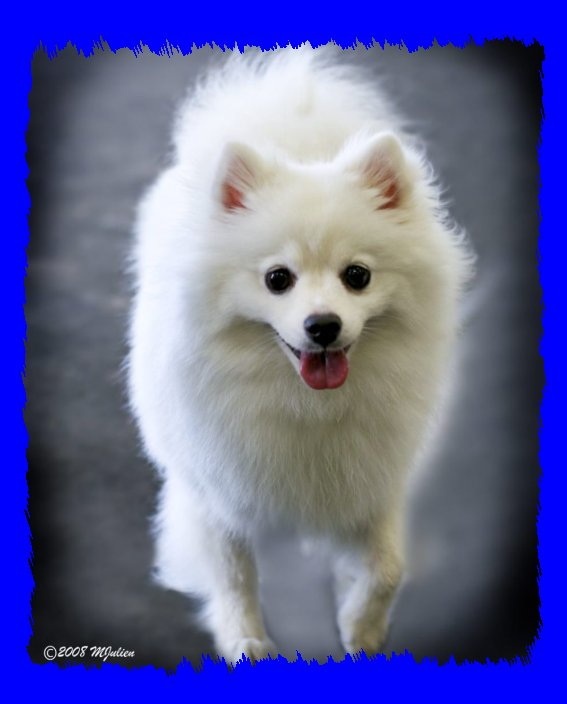

In [79]:
image

In [80]:
#image=unpickle(image_path)
image=np.resize(image, (3,240, 240))

In [81]:
type(image),image.shape

(numpy.ndarray, (3, 240, 240))

In [82]:
predictor

In [84]:
# TODO: Run an prediction on the endpoint
response = predictor.predict(image)
print(response)

In [ ]:
response

In [94]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [93]:
!tar cvf ProfilerReport.tar  ProfilerReport

ProfilerReport/
ProfilerReport/profiler-output/
ProfilerReport/profiler-output/profiler-report.ipynb
ProfilerReport/profiler-output/profiler-report.html
ProfilerReport/profiler-output/profiler-reports/
ProfilerReport/profiler-output/profiler-reports/StepOutlier.json
ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
ProfilerReport/profiler-output/profiler-reports/Dataloader.json
ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
ProfilerReport/profiler-output/profiler-reports/BatchSize.json
ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
